<a href="https://colab.research.google.com/github/sunyingjian/AI-in-well-logging/blob/master/self_attention%E7%9A%84transform_%E6%A8%A1%E5%9E%8B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[基于注意力的神经机器翻译](https://tensorflow.google.cn/tutorials/text/nmt_with_attention)

#引入框架

In [1]:
!pip install tf-nightly

     |████████████████████████████████| 393.5MB 42kB/s 
     |████████████████████████████████| 1.3MB 48.8MB/s 
     |████████████████████████████████| 471kB 55.7MB/s 
     |████████████████████████████████| 10.6MB 46.6MB/s 
     |████████████████████████████████| 14.5MB 239kB/s 
ERROR: tensorflow 2.3.0 has requirement numpy<1.19.0,>=1.16.0, but you'll have numpy 1.19.2 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: protobuf 3.12.4
    Uninstalling protobuf-3.12.4:
      Successfully uninstalled protobuf-3.12.4
  Found existing installation: numpy 1.18.5
    Uninstalling numpy-1.18.5:
      Successfully uninstalled numpy-1.18.5


In [1]:
!git clone https://github.com/sunyingjian/numpy-.git

Cloning into 'numpy-'...
remote: Enumerating objects: 23, done.
remote: Counting objects: 100% (23/23), done.
remote: Compressing objects: 100% (23/23), done.
remote: Total 347 (delta 1), reused 0 (delta 0), pack-reused 324
Receiving objects: 100% (347/347), 201.75 MiB | 23.51 MiB/s, done.
Resolving deltas: 100% (81/81), done.
Checking out files: 100% (190/190), done.


In [2]:
import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split

import unicodedata
import re
import numpy as np
import os
import io
import time

#导入数据

In [3]:
%matplotlib inline
#%matplotlib inline 可以在Ipython编译器里直接使用，功能是可以内嵌绘图，并且可以省略掉plt.show()这一步。
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_addons as tfa
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
from pandas import set_option
set_option("display.max_rows", 10)#设置要显示的默认行数，显示的最大行数是10
pd.options.mode.chained_assignment = None #为了在增加列表行数的时候防止出现setting with copy warning
training_data = pd.read_csv('/content/numpy-/3345train data.csv')
training_data
testing_data = pd.read_csv('/content/numpy-/3345test_data.csv')
testing_data

,AC,CAL,GR,K,RD,SP,Core Lithology
0,0.038756,0.026970,0.094776,0.112543,0.001420,0.614504,5
1,0.347382,0.090194,0.145150,0.202335,0.002744,0.339568,7
2,0.218400,0.059510,0.252165,0.711295,0.003874,0.918567,3
3,0.366064,0.082147,0.149304,0.201731,0.003290,0.343180,7
4,0.291877,0.079981,0.141782,0.289309,0.003455,0.344605,7
...,...,...,...,...,...,...,...
361,0.016947,0.138827,0.118400,0.358567,0.281687,0.302936,6
362,0.131043,0.069016,0.029354,0.060197,0.282093,0.253809,3
363,0.036182,0.032010,0.030090,0.071069,0.359737,0.435486,5
364,0.014562,0.127332,0.035014,0.178579,0.803566,0.311641,6


##数据预处理

In [4]:
a = training_data['Core Lithology'].value_counts()
a

7    928
3    751
2    710
5    482
1    194
4    166
6    114
Name: Core Lithology, dtype: int64

In [5]:
X_train = training_data.drop(columns='Core Lithology')
y_train = training_data['Core Lithology'].values

In [6]:
from imblearn.over_sampling import SMOTE
from collections import Counter
sm = SMOTE(sampling_strategy={5:700,1:700,4:700,6:700},random_state=24)
X_train_sm, y_train_sm = sm.fit_sample(X_train, y_train)

train_x_sm = pd.DataFrame(X_train_sm)
train_y_sm = pd.DataFrame(y_train_sm)

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/loca

In [7]:
train_x_sm['Core Lithology'] = y_train_sm
training_data_sm = train_x_sm

##设置步长

In [103]:
seq_length = 6
data_ = []
for i in range(len(training_data_sm)-seq_length):
  data_.append(training_data_sm.iloc[i:i+seq_length])

In [104]:
len(data_)

5183

In [105]:
data_ = np.array([df.values for df in data_])

In [106]:
data_.shape

(5183, 6, 7)

In [107]:
np.random.shuffle(data_)

In [108]:
train_x = data_[:,:,:6]

In [109]:
train_x.shape

(5183, 6, 6)

In [110]:
train_y = data_[:,:,-1]

In [111]:
train_y.shape

(5183, 6)

In [112]:
data_test = []
for i in range(len(testing_data)-seq_length):
  data_test.append(testing_data.iloc[i:i+seq_length])

In [113]:
data_test = np.array([df.values for df in data_test])

In [114]:
data_test.shape

(360, 6, 7)

In [115]:
test_x = data_test[:,:,:6]
test_x.shape

(360, 6, 6)

In [116]:
test_y = data_test[:,:,-1]

In [117]:
#独热编码
test_y = test_y-1

In [118]:
train_y = train_y-1

In [119]:
train_y = tf.keras.utils.to_categorical(train_y,7)

In [120]:
test_y = tf.keras.utils.to_categorical(test_y,7)

#transform

In [121]:
from tensorflow import keras
import math
import tensorflow_addons as tfa
import tensorflow as tf

In [122]:
input = tf.keras.Input(shape=(6,6))

In [137]:
ainput = tf.keras.layers.LSTM(6,return_sequences=True)(input)
x1 = tf.keras.layers.MultiHeadAttention(num_heads=6, key_dim=12, value_dim=None,dropout=0.5,kernel_regularizer='l2')(ainput,ainput)
x1 = tf.keras.layers.MultiHeadAttention(num_heads=6, key_dim=24, value_dim=None,dropout=0.5,kernel_regularizer='l2')(x1,x1)
x = tf.keras.layers.add([ainput,x1])
x1 = tf.keras.layers.LayerNormalization()(x)
x = tf.keras.layers.Dense(24,activation='relu')(x1)
x = tf.keras.layers.Dense(6)(x)
x = tf.keras.layers.add([x,x1])
x = tf.keras.layers.LayerNormalization()(x)
x1 = tf.keras.layers.MultiHeadAttention(num_heads=6, key_dim=24, value_dim=None,dropout=0.5,kernel_regularizer='l2')(x,x)
x1 = tf.keras.layers.MultiHeadAttention(num_heads=6, key_dim=24, value_dim=None,dropout=0.5,kernel_regularizer='l2')(x1,x1)
x = tf.keras.layers.add([x,x1])
x1 = tf.keras.layers.LayerNormalization()(x)
x = tf.keras.layers.Dense(24,activation='relu')(x1)
x = tf.keras.layers.Dense(6)(x)
x = tf.keras.layers.add([x,x1])
x = tf.keras.layers.LayerNormalization()(x)
x1 = tf.keras.layers.MultiHeadAttention(num_heads=6, key_dim=24, value_dim=None,dropout=0.5,kernel_regularizer='l2')(x,x)
x1 = tf.keras.layers.MultiHeadAttention(num_heads=6, key_dim=24, value_dim=None,dropout=0.5,kernel_regularizer='l2')(x1,x1)
x = tf.keras.layers.add([x,x1])
x1 = tf.keras.layers.LayerNormalization()(x)
x = tf.keras.layers.Dense(12,activation='relu')(x1)
x = tf.keras.layers.Dense(6)(x)
x = tf.keras.layers.add([x,x1])
x = tf.keras.layers.LayerNormalization()(x)
x = keras.layers.Dense(6,activation="linear")(x)
x = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(7,activation='softmax',kernel_regularizer='l2'))(x)
model = tf.keras.Model(inputs = input, outputs = x)

In [138]:
model.summary()

Model: "model_16"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 6, 6)]       0                                            
__________________________________________________________________________________________________
lstm_19 (LSTM)                  (None, 6, 6)         312         input_4[0][0]                    
__________________________________________________________________________________________________
multi_head_attention_49 (MultiH (None, 6, 6)         1950        lstm_19[0][0]                    
                                                                 lstm_19[0][0]                    
__________________________________________________________________________________________________
multi_head_attention_50 (MultiH (None, 6, 6)         3894        multi_head_attention_49[0]

In [139]:
#学习率衰减
learning_rate=0.001
def scheduler(epoch):
  if epoch<=200:
    learning_rate=0.001
  elif epoch<=300:
    learning_rate=0.0008
  elif epoch<=400:
    learning_rate=0.0006
  else:
    learning_rate=0.0005
  return learning_rate
  
Lr_change=keras.callbacks.LearningRateScheduler(scheduler)
#保存准确率最好的模型
from keras.callbacks import ModelCheckpoint
filepath="/content/drive/My Drive/best_weight.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True,mode='max')

#Adam优化器
Adam=keras.optimizers.Adam(learning_rate=learning_rate)
model.compile(optimizer=Adam,loss='categorical_crossentropy',
              metrics=['acc'])

In [ ]:
history=model.fit(train_x,train_y,batch_size=128 ,
         epochs=600,
         callbacks=[Lr_change,checkpoint],
         validation_data=(test_x,test_y))

Epoch 1/600
41/41 [==============================] - 6s 52ms/step - loss: 3.3398 - acc: 0.1552 - val_loss: 2.7739 - val_acc: 0.2477

Epoch 00001: val_acc improved from -inf to 0.24769, saving model to /content/drive/My Drive/best_weight.h5
Epoch 2/600
41/41 [==============================] - 1s 32ms/step - loss: 2.5664 - acc: 0.3178 - val_loss: 2.3730 - val_acc: 0.3236

Epoch 00002: val_acc improved from 0.24769 to 0.32361, saving model to /content/drive/My Drive/best_weight.h5
Epoch 3/600
41/41 [==============================] - 1s 31ms/step - loss: 2.1199 - acc: 0.4038 - val_loss: 2.1566 - val_acc: 0.3134

Epoch 00003: val_acc did not improve from 0.32361
Epoch 4/600
41/41 [==============================] - 1s 32ms/step - loss: 1.8686 - acc: 0.4450 - val_loss: 2.0197 - val_acc: 0.2866

Epoch 00004: val_acc did not improve from 0.32361
Epoch 5/600
41/41 [==============================] - 1s 32ms/step - loss: 1.7129 - acc: 0.4635 - val_loss: 1.9323 - val_acc: 0.2843

Epoch 00005: val_a

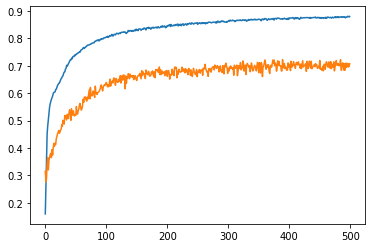

In [64]:
plt.plot(history.epoch,history.history.get('acc'),label='acc')
plt.plot(history.epoch,history.history.get('val_acc'),label='val_acc')

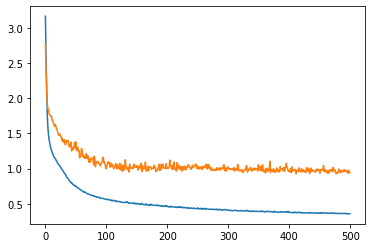

In [65]:
plt.plot(history.epoch,history.history.get('loss'),label='loss')
plt.plot(history.epoch,history.history.get('val_loss'),label='val_loss')